# Лабораторная работа №3
### Конечномерная оптимизация, градиентные методы. Реализация на GPU.

### Постановка задачи

Сравнить реализации Gradient Descent из лабораторной работы 1 с реализацией на GPU с помощью numba

In [1]:
''' Imports '''
from typing import Tuple, Mapping, Callable, Dict
from IPython import display

import numpy as np
import random

from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

## Gradient Descent

In [11]:
def GradientDescent(
    f: Callable, df: Callable, 
    x0: np.ndarray,
    lr: float = 0.001,
    T: int = 100,
    is_enable_lrs: bool = False,
    lre: int = 7, g: float = 0.1
    ) -> dict:
    '''
    Нативная реализация градиентного спуска
    
    Args:
        f (Callable): Функционал для оптимизации
        df (Callable): Градиент оптимизирующего функционала
        x0 (np.ndarray): Стартовая точка
        lr (float): Скорость обучения. Default=0,01.
        T (int): Количество итераций.
        is_enable_lrs(bool): Активировать модификацию Learning Rate Schedule
        lre (int): Через сколько эпох мы уменьшим lr. Default = 7. [Aктивно только при is_enable_lrs == True]
        g (float): Коэфициент уменьшения lr [0,1). Default = 0.1.  [Aктивно только при is_enable_lrs == True]
    
    Returns:
        Dict - Данные о работе оптимизации функции:
            'x_optimal'      - [np.ndarray] оптимальное расположение точки.
            'optimum_value'  - [np.float32] значение минимизируемой функции в 
                                точке найденного оптимума.
    '''
    
    assert(T >= 1)
    assert(callable(f))
    assert(callable(df))
    assert(lr > 0)
    assert(lre > 0)
    assert(g < 1 and g >= 0)
    
    x_old = x0.copy()
    for i in range(T):
        
        if i % lre == 0 and is_enable_lrs:
            lr *= g
            
        grad = df(x_old)
        x_new = x_old - lr * grad
        x_old = x_new.copy()
        
    return {'x_optimal': x_new, 'optimum_value': f(x_new)}

## Функция Химмельблау

$$ f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2 $$

In [12]:
def Himmelblau(x: np.ndarray) -> np.float64:
    '''
    Функция Химмельблау
    
    Args:
        x(np.ndarray): Вектор аргументов. Не менее двух элемегнтов в массиве.
        
    Returns:
        np.float64: Результат функции
    '''
    
    if np.size(x) < 2:
        raise ValueError(f'Input argument for Himmelblau function: X input size is {np.size(x)}, expected: 2 or greater.')
        
    return np.square(np.square(x[0]) + x[1] - 11) + np.square(x[0] + np.square(x[1]) - 7);


def HimmelblauGradient(x: np.ndarray) -> np.ndarray:
    '''
    Градиент функции Himmelblau.
    
    Args:
        x(np.ndarray): Вектор аргументов. Не менее двух элемегнтов в массиве.
        
    Returns:
        np.ndarray: Градиент функции Himmelblau в точке X.
    '''
    return np.array([
            (4 * x[0] * (np.square(x[0]) + x[1] - 11) + 2 * (x[0] + np.square(x[1]) - 7)), 
            (2 * (np.square(x[0]) + x[1] - 11) + 4 * x[1] * (x[0] + np.square(x[1]) - 7))
        ]);

In [13]:
def print_title(*args, indent_size: int = 30, sym:str = '='):
    '''
    Форматированный вывод заголовков через print.
    
    Args:
        indent_size(int)[Optional]: Размер отступов заголовка слева и справа
        sym(str)[Optional]: Символ для отступа заголовка
    '''
    print(sym * indent_size, *args, sym * indent_size)

In [14]:
def plot_colormesh(
    f: Callable, 
    ranges: Tuple, 
    step: Tuple[float, float],
    figsize: Tuple[int, int] = (15, 10),
    title: str = "Title",
    colormap: str = 'PiYG',
    nbins:int = 100,
    ):

    dx, dy = step[0], step[1]

    y, x = np.mgrid[
                slice(ranges[0][0], ranges[0][1] + dy, dy),
                slice(ranges[1][0], ranges[1][1] + dx, dx)
            ]
    
    z = f([x, y])[:-1, :-1]

    levels = MaxNLocator(nbins=nbins).tick_values(z.min(), z.max())

    cmap = plt.colormaps[colormap]
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    fig, ax = plt.subplots(figsize=figsize)

    cf = ax.contourf(x[:-1, :-1] + dx/2.,
                      y[:-1, :-1] + dy/2., z, levels=levels,
                      cmap=cmap)
    fig.colorbar(cf, ax=ax)
    ax.set_title(title)

    fig.tight_layout()
    return fig, ax

Gradient Descent result:
	Found optimum coodrinates: [-3.77931025 -3.28318599]
	Found optimum value      : 4.5753932502818685e-28


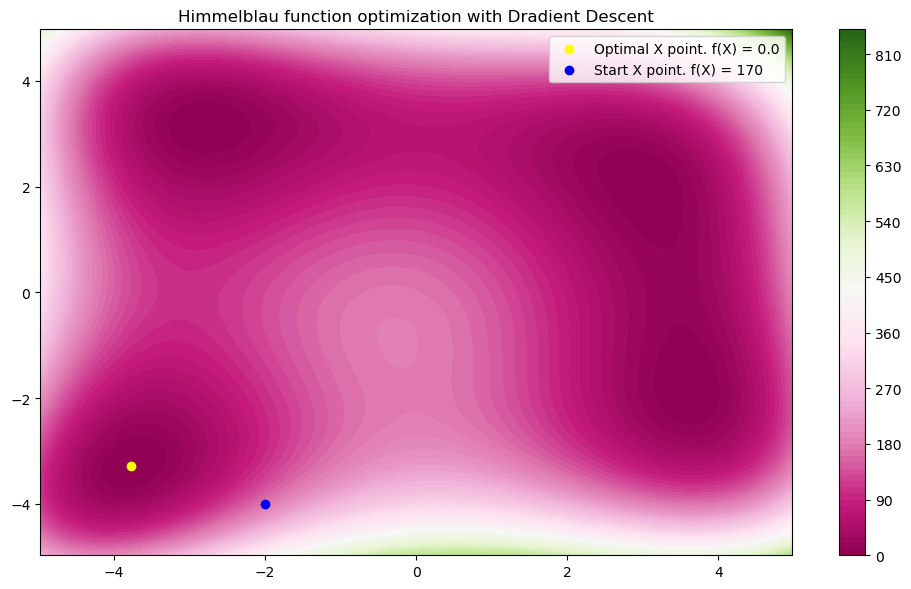

In [15]:
fig, ax = plot_colormesh(
    Himmelblau, 
    ranges=((-5, 5), (-5, 5)), 
    step=(0.05, 0.05), 
    figsize=(10, 6), 
    title="Himmelblau function optimization with Dradient Descent"
)

start_point = np.array([-2, -4])

gradient_descent_result = GradientDescent(Himmelblau, HimmelblauGradient, start_point, T=1000)

print("Gradient Descent result:")
print("\tFound optimum coodrinates:", gradient_descent_result['x_optimal'])
print("\tFound optimum value      :", gradient_descent_result['optimum_value'])

point = gradient_descent_result['x_optimal']
value = gradient_descent_result['optimum_value']
ax.scatter(point[0], point[1], color='yellow', label=f'Optimal X point. f(X) = {round(value, 4)}')
ax.scatter(start_point[0], start_point[1], color='blue', label=f'Start X point. f(X) = {round(Himmelblau(start_point), 4)}')
ax.legend()
plt.show()

## Gradient Descent GPU

In [16]:
import numba
from numba import jit

In [31]:
@numba.njit(fastmath=True)
def GradientDescentGPU(
    f: Callable, df: Callable, 
    x0: np.ndarray,
    lr: float = 0.001,
    T: int = 100,
    is_enable_lrs: bool = False,
    lre: int = 7, g: float = 0.1
    ) -> dict:
    '''
    Нативная реализация градиентного спуска
    
    Args:
        f (Callable): Функционал для оптимизации
        df (Callable): Градиент оптимизирующего функционала
        x0 (np.ndarray): Стартовая точка
        lr (float): Скорость обучения. Default=0,01.
        T (int): Количество итераций.
        is_enable_lrs(bool): Активировать модификацию Learning Rate Schedule
        lre (int): Через сколько эпох мы уменьшим lr. Default = 7. [Aктивно только при is_enable_lrs == True]
        g (float): Коэфициент уменьшения lr [0,1). Default = 0.1.  [Aктивно только при is_enable_lrs == True]
    
    Returns:
        Dict - Данные о работе оптимизации функции:
            'x_optimal'      - [np.ndarray] оптимальное расположение точки.
            'optimum_value'  - [np.float32] значение минимизируемой функции в 
                                точке найденного оптимума.
    '''
    x_old = x0.copy()
    for i in range(T):
        
        if i % lre == 0 and is_enable_lrs:
            lr *= g
            
        grad = df(x_old)
        x_new = x_old - lr * grad
        x_old = x_new.copy()
        
    return x_new

In [29]:
@numba.njit(fastmath=True)
def HimmelblauGPU(x):
    '''
    Функция Химмельблау
    
    Args:
        x(np.ndarray): Вектор аргументов. Не менее двух элемегнтов в массиве.
        
    Returns:
        np.float64: Результат функции
    '''
    return np.square(np.square(x[0]) + x[1] - 11) + np.square(x[0] + np.square(x[1]) - 7);


@numba.njit(fastmath=True)
def HimmelblauGradientGPU(x):
    '''
    Градиент функции Himmelblau.
    
    Args:
        x(np.ndarray): Вектор аргументов. Не менее двух элемегнтов в массиве.
        
    Returns:
        np.ndarray: Градиент функции Himmelblau в точке X.
    '''
    return np.array([
            (4 * x[0] * (np.square(x[0]) + x[1] - 11) + 2 * (x[0] + np.square(x[1]) - 7)), 
            (2 * (np.square(x[0]) + x[1] - 11) + 4 * x[1] * (x[0] + np.square(x[1]) - 7))
        ]);

Gradient Descent result:
	Found optimum coodrinates: [-3.77931025 -3.28318599]
	Found optimum value      : 4.763124743489223e-28


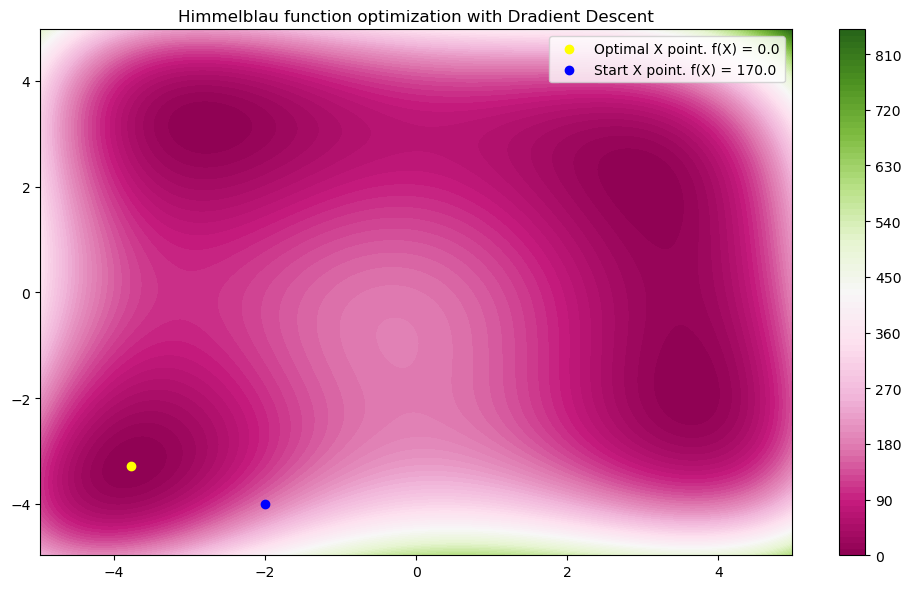

In [37]:
fig, ax = plot_colormesh(
    Himmelblau, 
    ranges=((-5, 5), (-5, 5)), 
    step=(0.05, 0.05), 
    figsize=(10, 6), 
    title="Himmelblau function optimization with Dradient Descent"
)

start_point = np.array([-2.0, -4.0], dtype=np.float64)

gradient_descent_result = GradientDescentGPU(HimmelblauGPU, HimmelblauGradientGPU, start_point, T=1000)

print("Gradient Descent result:")
print("\tFound optimum coodrinates:", gradient_descent_result)
print("\tFound optimum value      :", HimmelblauGPU(gradient_descent_result))

point = gradient_descent_result
value = HimmelblauGPU(gradient_descent_result)
ax.scatter(point[0], point[1], color='yellow', label=f'Optimal X point. f(X) = {round(value, 4)}')
ax.scatter(start_point[0], start_point[1], color='blue', label=f'Start X point. f(X) = {round(Himmelblau(start_point), 4)}')
ax.legend()
plt.show()

## Сравнение времени работы

In [39]:
%timeit -n 100 GradientDescent(HimmelblauGPU, HimmelblauGradientGPU, start_point, T=1000)

2.38 ms ± 81.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
%timeit -n 100 GradientDescentGPU(HimmelblauGPU, HimmelblauGradientGPU, start_point, T=1000)

282 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
